In [1]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
sns.set('paper','whitegrid', font_scale=2, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

In [2]:
def get_summary_progress(local_dir: str, expt_name: str = None):
    summary_progress = {}
    expt_names = glob.glob(os.path.join(local_dir, "*_*"))
    for expt_name in expt_names:
        splits = expt_name.split("\\")[-1].split("__")
        if len(splits) == 3:
            algo, env_params, timelog = splits
        else:
            algo, timelog = splits
            env_params = "default"
        trials = glob.glob(os.path.join(expt_name, "ExperimentCV_*"))
        
        summary_trials = {}
        try:
            for trial in trials:
                with open(os.path.join(trial, "params.json"), 'r') as f:
                    params = json.load(f)
                train_start = datetime.strptime(params["_train_start"], "%Y-%m-%d") + relativedelta(years=params["__trial_index__"])
                eval_start = datetime.strptime(params["_train_start"], "%Y-%m-%d") + relativedelta(years=params["__trial_index__"] + params["_train_years"])
                column_name = f"{train_start.year}(+{params['_train_years']}) | {eval_start.year}(+{params['_eval_years']})"
                
                progress = pd.read_csv(os.path.join(trial, "progress.csv"))
                summary_trials[column_name] = progress
        except FileNotFoundError as e:
            pass
        
        summary_progress[f"{algo}_{env_params}"] = summary_trials

    return summary_progress

In [3]:
# summary_progress = get_summary_progress("./ray_results/compare-action-3")
summary_progress = get_summary_progress("./ray_results/features_selection_custom")

In [4]:
def plot_target_mean(summary_progress, target: str = "episode_reward_mean"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    title = "Cumulative reward"
    title += " (eval)" if "evaluation" in target else " (train)"
    ax.set_title(title)
    for expt, trial_dict in summary_progress.items():
        target_cv = pd.DataFrame()
        for trial, progress in trial_dict.items():
            # target = progress[[target, "timesteps_total"]].set_index("timesteps_total")
            progress: pd.DataFrame = progress[[target, "timesteps_total"]].set_index("timesteps_total").rename(columns={target: trial})
            target_cv = pd.concat([target_cv, progress], axis=1)
            # ax.plot(progress["timesteps_total"], progress[target], label=trial)
            
        target_cv_mean = target_cv.mean(axis=1)
        ax.plot(target_cv_mean.rolling(window=5).mean(), label=expt)
        # print(target_df)
        # target_df.plot()
        # ax.plot(progress["timesteps_total"], progress[target], label=trial)
    ax.legend(loc="upper left")
    ax.grid(True)
    ax.set_ylabel("Cum Reward")
    ax.set_xlabel("Timesteps")

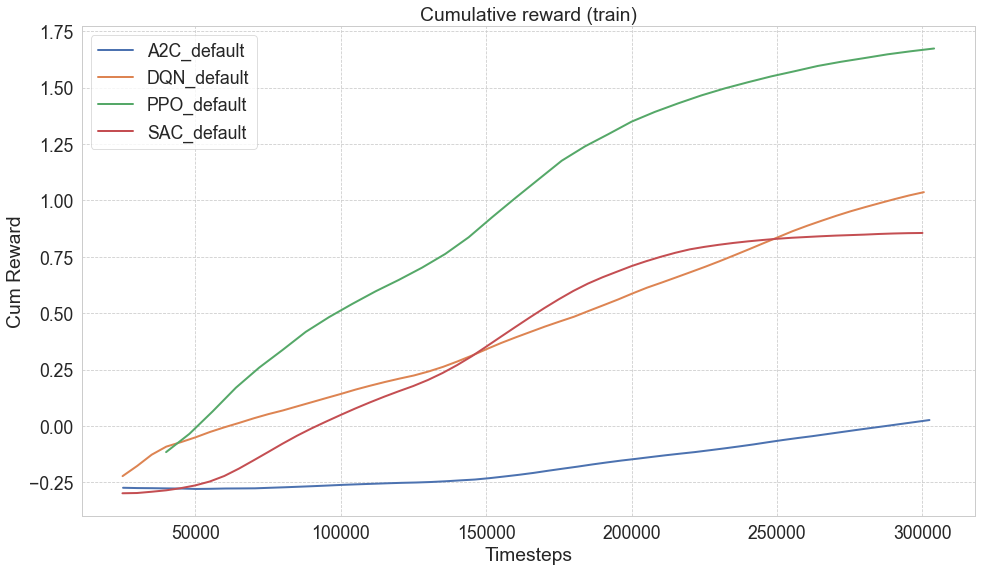

In [5]:
plot_target_mean(summary_progress, "episode_reward_mean")

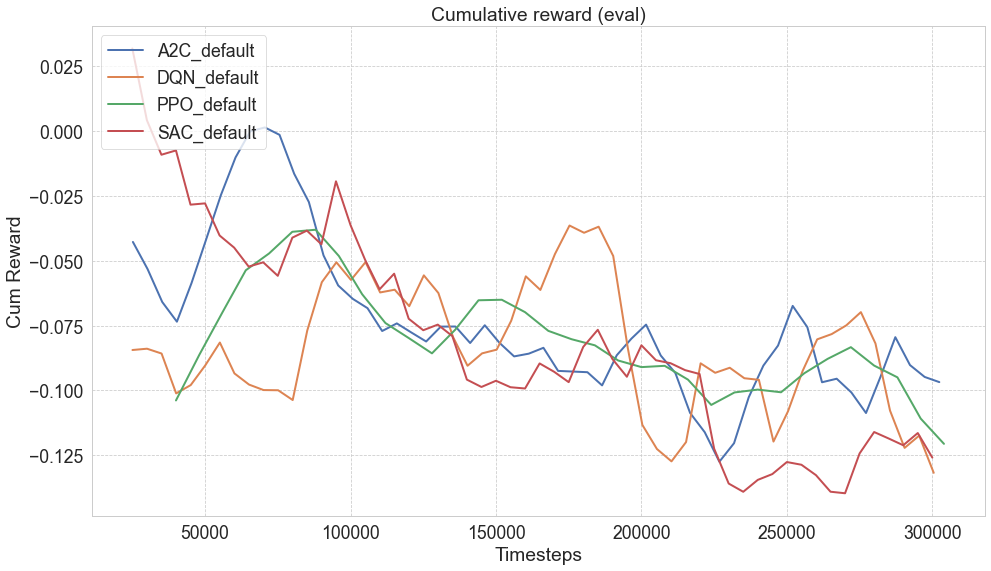

In [6]:
plot_target_mean(summary_progress, "evaluation/episode_reward_mean")

In [7]:
# # sns.set('paper','whitegrid', font_scale=5, rc={"lines.linewidth": 5})
# sns.set('paper','whitegrid', font_scale=7, rc={"lines.linewidth": 7, 'grid.linestyle': '--'})
# fig, axes = plt.subplots(1, 2, figsize=(30, 18))
# # axes[0].text(0.95, 0.01, "Training", transform=axes[0].transAxes)
# axes[0].set_title("Training")
# axes[0].set_ylabel("Reward")
# axes[0].set_xlabel("Timesteps")
# axes[0].set_xticks([0, 250000, 500000])


# # axes[1].text(0.01, 0.95, "Test", transform=axes[1].transAxes)
# axes[1].set_title("Test")
# axes[1].set_ylabel("Reward")
# axes[1].set_xlabel("Timesteps")
# axes[1].set_xticks([0, 250000, 500000])
# for algo, progress in summary_progress.items():
#     train_rewards = progress["episode_reward_mean"].rolling(5).mean()
#     test_rewards = progress["evaluation/episode_reward_mean"].rolling(5).mean()
#     axes[0].plot(progress["timesteps_total"], train_rewards, label=algo)
#     axes[1].plot(progress["timesteps_total"], test_rewards, label=algo)
#     # progress["episode_reward_mean"].ewm(5).mean().plot(x=progress["timesteps_total"], ax=axes[0])
#     # progress["evaluation/episode_reward_mean"].ewm(5).mean().plot(x=progress["timesteps_total"], ax=axes[1], label=algo, legend=True).legend(loc='lower right')

# # axes[0].legend()
# axes[0].legend(loc='upper left')

# # axes[1].legend()
# # axes[1].legend(loc='upper left')
# plt.tight_layout()